# Computer Lab 1: Ocean Tides
This notebook will contain the code and write-ups for parts (1) and (3) through (5) of the Ocean Tides assignment. Parts (2), (6), and (7) will be written up separately.

## Setup
Let's begin by loading some helpful packages. We need `matplotlib.pyplot` to create plots of our data and analyses, `pandas` to open and work with our data, and `numpy` for our linear algebra needs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Let's also set `numpy` to print arrays in a more readable notation:

In [2]:
np.set_printoptions(suppress = True)

## Part (1)
Part (1) just asks us to run the given MATLAB code to create a plot of the tidal data. However, since we are using Python, we will have to put in some extra work to recreate the provided script. I've copied the given tidal data into a CSV file, and below is a script to create a plot of said data.

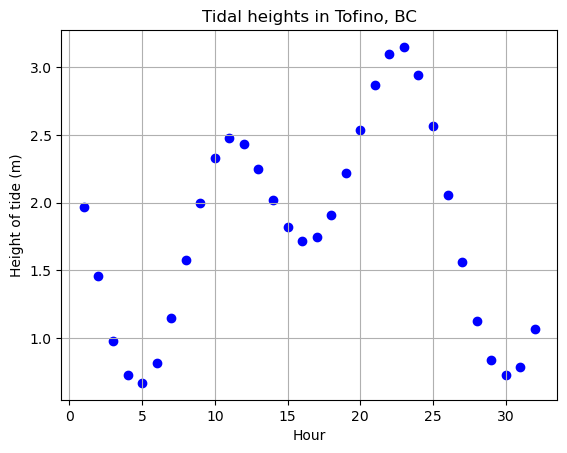

In [3]:
# Import data
df = pd.read_csv("heights.csv")
times = df['time']
heights = df['height']

# Set up figure
fig, ax = plt.subplots()

# Plot data
ax.scatter(times, heights, color = "blue")

# Label plot
ax.set_xlabel("Hour")
ax.set_ylabel("Height of tide (m)")
ax.set_title("Tidal heights in Tofino, BC")
ax.grid()

## Part (3)
Now, we are asked to use quadratic interpolation on our data, first to estimate a single data point, then for a series of data points across our time period. We can begin both of these by setting up a linear system of equations with our data:  
  
$$ \mathbf{y} = \mathbf{Ex} \rightarrow \mathbf{x} = \mathbf{E}^{-1}\mathbf{y}$$  
  
where $\mathbf{y}$ is the vector containing our observed data; $\mathbf{E}$ is the matrix containing the times of our observation raised to the powers of $0$, $1$, and $2$; and $\mathbf{x}$ is the vector containing the coefficients of our linear system of equations.

First, we want to interpolate the `time = 20.5` data point. Let's choose the data points at $19$, $20$, and $21$ hours to calculate our quadratic interpolation; we can now define our $\mathbf{y}$ and $\mathbf{E}$ for these three data points.

In [4]:
# Convert y to a numpy array
# Recall that Python is zero-indexed and end-exclusive,
# so 18:21 includes indices 18, 19, and 20 and thus 
# times 19, 20, and 21.
y = np.array(heights[18:21])

# Technically speaking, there are more succinct ways to define E,
# but this definition shows what we're doing mathematically
# much more explicitly
E = np.array([np.power(times[18:21], 0),
              np.power(times[18:21], 1),
              np.power(times[18:21], 2)]).T

# Confirm that everything looks right
print(y)
print(E)

[2.22 2.54 2.87]
[[  1.  19. 361.]
 [  1.  20. 400.]
 [  1.  21. 441.]]


We can find $\mathbf{E}^{-1}$ using `numpy`, too:

In [5]:
E_inv = np.linalg.inv(E)
print(E_inv)

[[ 210.  -399.   190. ]
 [ -20.5   40.   -19.5]
 [   0.5   -1.     0.5]]


Now, we can calculate $\mathbf{x}$, our coeefficient vector:

In [6]:
x = np.matmul(E_inv, y)
print(x)

[-1.96   0.125  0.005]


And estimate the tidal height at `time = 20.5`:

In [7]:
time_est = np.array([20.5 ** i for i in range (0, 3)])
y_est = np.matmul(time_est, x)

Before we move on to the repeated quadratic interpolation, let's graph our estimate as a sanity check:

<Figure size 640x480 with 0 Axes>

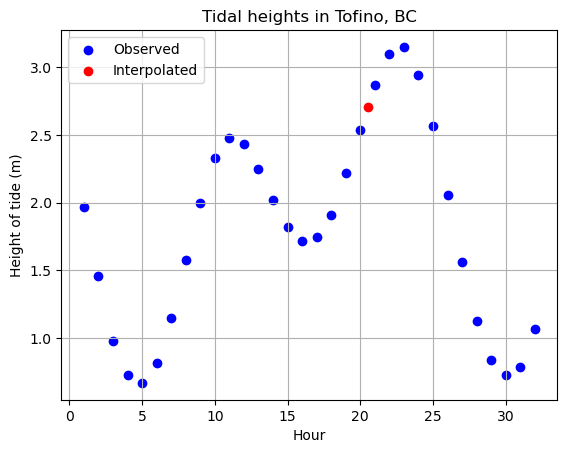

In [8]:
# Set up figure
plt.clf()
fig, ax = plt.subplots()

# Plot data
data_scatter = ax.scatter(times, heights,
                          color = "blue", label = "Observed")
est_scatter = ax.scatter(20.5, y_est, 
                         color = "red", label = "Interpolated")

# Label plot
ax.set_xlabel("Hour")
ax.set_ylabel("Height of tide (m)")
ax.set_title("Tidal heights in Tofino, BC")
ax.legend(loc = "upper left")
ax.grid()

And recapitulate our values of $\mathbf{y}$, $\mathbf{E}$, $\mathbf{E}^{-1}$, and $\mathbf{x}$:

In [9]:
print("y = " + str(y))
print("\nE = " + str(E))
print("\nE⁻¹ = " + str(E_inv))
print("\nx = " + str(x))

y = [2.22 2.54 2.87]

E = [[  1.  19. 361.]
 [  1.  20. 400.]
 [  1.  21. 441.]]

E⁻¹ = [[ 210.  -399.   190. ]
 [ -20.5   40.   -19.5]
 [   0.5   -1.     0.5]]

x = [-1.96   0.125  0.005]


Our interpolated value seems to be a pretty good estimate, so let's move on to the repeated case. We want to interpolate the tidal height every six minutes, which means every $\frac{1}{10}$ hours. As a general rule, let's set up our interpolation to use one data point before the time of interpolation and two after; this will work until the `time = 31` mark, which we can handle separately. Let's start with the general case:

In [10]:
# Set up time range and remove times already in data set
interp_times = np.array([i / 100 for i in range(110, 3100, 10)])
interp_times = interp_times[interp_times % 1 != 0]

# Iterate through times
estimations = []
for itime in interp_times:
    
    # Find index of most recent time point
    start_index = np.where(times == np.floor(itime))
    start_index = int(start_index[0])
    
    # Find the latter index
    end_index = start_index + 3
    
    # Define y and E with indices
    y = np.array(heights[start_index:end_index])
    E = np.array([np.power(times[start_index:end_index], 0),
                  np.power(times[start_index:end_index], 1),
                  np.power(times[start_index:end_index], 2)]).T
    
    # Find the inverse of E and calculate x
    E_inv = np.linalg.inv(E)
    x = np.matmul(E_inv, y)
    
    # Estimate tidal height
    time_est = np.array([itime ** i for i in range (0, 3)])
    y_est = np.matmul(time_est, x)
    
    # Add to array
    estimations.append(y_est)

For the interpolations after `time = 31`, we can modify the code as follows:

In [11]:
# Set up time range and remove times already in data set
interp_times = np.array([i / 100 for i in range(3110, 3200, 10)])
interp_times = interp_times[interp_times % 1 != 0]

# Iterate through times
for itime in interp_times:
    
    # Find index of most recent time point
    start_index = np.where(times == np.floor(itime))
    start_index = int(start_index[0]) - 1

    # Define y and E with indices
    y = np.array(heights[start_index:])
    E = np.array([np.power(times[start_index:], 0),
                  np.power(times[start_index:], 1),
                  np.power(times[start_index:], 2)]).T
    
    # Find the inverse of E and calculate x
    E_inv = np.linalg.inv(E)
    x = np.matmul(E_inv, y)
    
    # Estimate tidal height
    time_est = np.array([itime ** i for i in range (0, 3)])
    y_est = np.matmul(time_est, x)
    
    # Add to array
    estimations.append(y_est)

We can plot these estimations similar to the `time = 20.5` case, too:

<Figure size 640x480 with 0 Axes>

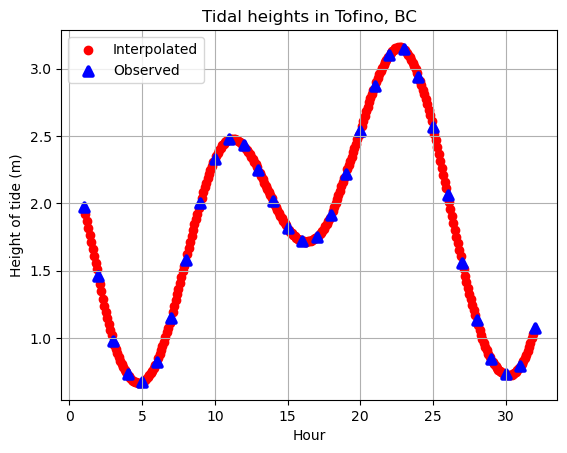

In [12]:
# Set up figure
plt.clf()
fig, ax = plt.subplots()

# Define interpolation times
interp_times = np.array([i / 100 for i in range(110, 3200, 10)])
interp_times = interp_times[interp_times % 1 != 0]

# Plot data; modify markers to show clearer difference
est_scatter = ax.scatter(interp_times, estimations, linewidth = 1,
                         color = "red", label = "Interpolated")
data_scatter = ax.scatter(times, heights, linewidth = 3, marker = "^",
                          color = "blue", label = "Observed")

# Label plot
ax.set_xlabel("Hour")
ax.set_ylabel("Height of tide (m)")
ax.set_title("Tidal heights in Tofino, BC")
ax.legend(loc = "upper left")
ax.grid()

## Part (4)
Now, we are asked to utilize the quadratic fit from the last three data points to forecast tidal heights for the next eight hours. Let's begin by ensuring that we still have $\mathbf{y}$, $\mathbf{E}$, $\mathbf{E}^{-1}$, and $\mathbf{x}$ stored from our last iteration above.

In [13]:
print("y = " + str(y))
print("\nE = " + str(E))
print("\nE⁻¹ = " + str(E_inv))
print("\nx = " + str(x))

y = [0.73 0.79 1.07]

E = [[   1.   30.  900.]
 [   1.   31.  961.]
 [   1.   32. 1024.]]

E⁻¹ = [[ 496.  -960.   465. ]
 [ -31.5   62.   -30.5]
 [   0.5   -1.     0.5]]

x = [101.23  -6.65   0.11]


Next, we can define our time matrix on six-minute intervals between $32$ and $40$ hours, and extrapolate over those intervals.

In [14]:
# Define range of times
extrap_times = [i / 100 for i in range(3210, 4010, 10)]

# Iterate through times
extrapolations = []
for etime in extrap_times:
    
    # Estimate tidal height
    time_est = np.array([etime ** i for i in range (0, 3)])
    y_est = np.matmul(time_est, x)
    
    # Add to array
    extrapolations.append(y_est)

Let's plot those new extrapolations together with our interpolations and observed data points.

<Figure size 640x480 with 0 Axes>

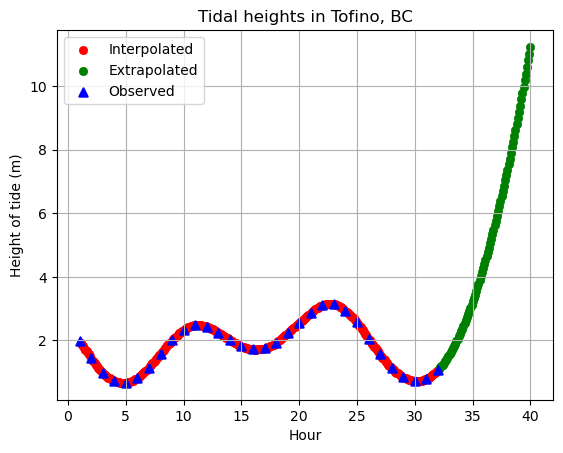

In [15]:
# Set up figure
plt.clf()
fig, ax = plt.subplots()

# Plot data
est_scatter = ax.scatter(interp_times, estimations, linewidth = 0.5,
                         color = "red", label = "Interpolated")
pred_scatter = ax.scatter(extrap_times, extrapolations, linewidth = 0.5,
                          color = "green", label = "Extrapolated")
data_scatter = ax.scatter(times, heights, linewidth = 1.5, marker = "^",
                          color = "blue", label = "Observed")

# Label plot
ax.set_xlabel("Hour")
ax.set_ylabel("Height of tide (m)")
ax.set_title("Tidal heights in Tofino, BC")
ax.legend(loc = "upper left")
ax.grid()

This prediction is clearly a very dramatic shift from what we've seen before, reaching heights over triple the previous maximum. With what we know about the oscillatory nature of ocean tides, this extrapolation is likely impossible to actually occur. However, we see these results because a quadratic &mdash; or any polynomial &mdash; function $f(x)$ will eventually tend to either positive or negative infinity in both directions of $x$, so our interpolation steeply increasing is a result of the natural end behavior of quadratic functions. This tells us that in an instance such as ocean tides, where we expect behavior more constrained to a certain range of values, a quadratic fit may not be the best decision for extrapolation.

## Part (5)
To correct for the issues with fitting a quadratic function to a tidal cycle, we are now asked to use regression to a harmonic function to predict the tidal cycles. We know that the formula for such a set-up is  
$$ \mathbf{y}=\overline{y}\cdot\mathbb{1}+\mathbf{Ex} $$  
so we can begin by rearranging our formula to  
$$ \mathbf{y}-\overline{y}\cdot\mathbb{1}=\mathbf{Ex} $$  
thus subtracting our mean tidal height from our observed data.  
  
*Note that here,* $\mathbb{1}$ *denotes a vector of all* $1$*s.*

In [16]:
y_adj = np.subtract(heights, np.mean(heights))

We can also set up $\mathbf{E}$ by recalling that in the case with two frequencies  

$$\mathbf{E} = \begin{bmatrix}
                    \cos(2\pi f_1 t_1) & \sin(2\pi f_1 t_1) & \cos(2\pi f_2 t_1) & \sin(2\pi f_2 t_1) \\ 
                    \vdots & \vdots & \vdots & \vdots \\
                    \cos(2\pi f_1 t_n) & \sin(2\pi f_1 t_n) & \cos(2\pi f_2 t_n) & \sin(2\pi f_2 t_n)
               \end{bmatrix}$$  
  
and we are given $f_1 = 0.04178$ cycles per hour and $f_2 = 0.08051$ cycles per hour.

In [17]:
# Define frequencies
f_1 = 0.04178
f_2 = 0.08051
pf_1 = 2 * np.pi * f_1
pf_2 = 2 * np.pi * f_2

# Set up E
E = np.array([np.cos(np.multiply(pf_1, times)),
              np.sin(np.multiply(pf_1, times)),
              np.cos(np.multiply(pf_2, times)),
              np.sin(np.multiply(pf_2, times))]).T

Since $\mathbf{E}$ isn't square, we must use the pseudoinverse, $(\mathbf{E}^T\mathbf{E})^{-1}\mathbf{E}^T$, to find $\mathbf{x}$. Then, $\mathbf{x}=(\mathbf{E}^T\mathbf{E})^{-1}\mathbf{E}^T\mathbf{y}_\mathrm{adj}$ can be calculated.

In [18]:
E_pseudoinv = np.matmul(np.linalg.inv(np.matmul(E.T, E)), E.T)
x = np.matmul(E_pseudoinv, y_adj)
print(x)

[ 0.21051534 -0.51315418  0.50670129 -0.57394745]


Let's now set up a vector of times every hour from `time = 1` to `time = 40` to use our fitted harmonic regression on, and calculate our predictions.

In [19]:
# Set up array of times
t = np.array([i for i in range(1, 41)])

# Calculate predicted E
E_pred = np.array([np.cos(np.multiply(pf_1, t)),
                   np.sin(np.multiply(pf_1, t)),
                   np.cos(np.multiply(pf_2, t)),
                   np.sin(np.multiply(pf_2, t))]).T

# Store average tidal height
y_bar = np.mean(heights)

# Predict heights
y_pred = np.add(y_bar, np.matmul(E_pred, x))

Let's plot our harmonic predictions to see how they shape up against the observed data.

<Figure size 640x480 with 0 Axes>

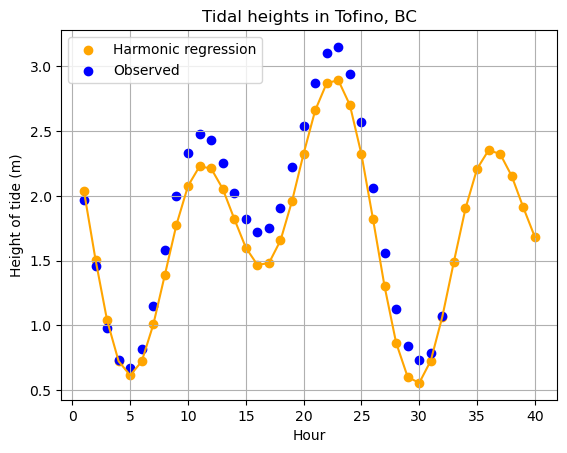

In [20]:
# Set up figure
plt.clf()
fig, ax = plt.subplots()

# Plot data
pred_lines = ax.plot(t, y_pred, color = "orange")
pred_scatter = ax.scatter(t, y_pred, color = "orange", label = "Harmonic regression")
data_scatter = ax.scatter(times, heights, color = "blue", label = "Observed")

# Label plot
ax.set_xlabel("Hour")
ax.set_ylabel("Height of tide (m)")
ax.set_title("Tidal heights in Tofino, BC")
ax.legend(loc = "upper left")
ax.grid()

The difference between harmonic interpolation and quadratic interpolation is clear; the quadratic estimates, by design, go through each data point, while the harmonic estimates are close to the observed data but rarely the exact same. However, the extrapolation provided by the harmonic estimate seems significantly more realistic than the quadratic estimate. As mentioned above, this is due to the oscillatory nature of ocean tides, which regression to harmonic functions accounts for.

<span style="color:red">TODO: Find amplitude and phase of each component</span>